In [50]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import dataloader
import matplotlib.pyplot as plt

In [51]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [52]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

In [53]:
test_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

In [54]:
img, label = train_data[0]
print(img.shape)

torch.Size([1, 28, 28])


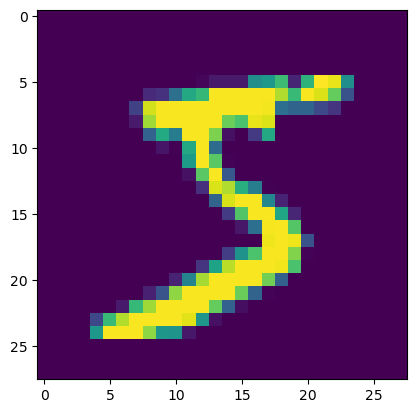

In [55]:
plt.imshow(img.squeeze())

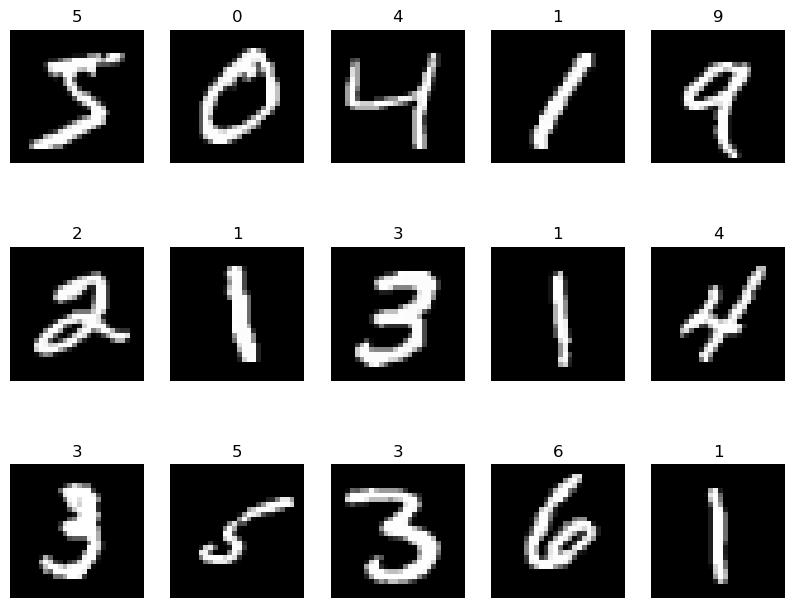

In [56]:
plt.figure(figsize=(10,8))

for i in range(15):
    img, label = train_data[i]
    plt.subplot(3, 5, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.show()

In [57]:
train_loader = dataloader.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = dataloader.DataLoader(dataset=test_data, batch_size=64, shuffle=True)

In [58]:
device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

In [59]:
output = len(train_data.classes)

In [60]:
class VGG_MNIST(nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*7*7, out_features=output)
        )
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


model = VGG_MNIST(input=1, hidden=32, output=output).to(device)
model

VGG_MNIST(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 5


for epoch in range(epochs):
    model.train()
    for X, y in train_loader:
        X = X.to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)
        y_train_logits = model(X)
        y_train_loss = criterion(y_train_logits, y)
        y_train_preds = torch.argmax(y_train_logits, dim=1)
        y_train_acc = (y_train_preds == y).float().mean()
        optimizer.zero_grad()
        y_train_loss.backward()
        optimizer.step()

    model.eval()
    for X, y in test_loader:
        X = X.to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)
        y_test_logits = model(X)
        y_test_loss = criterion(y_test_logits, y)
        y_test_preds = torch.argmax(y_test_logits, dim=1)
        y_test_acc = (y_test_preds == y).float().mean()

    print(f"Epoch: {epoch} || Train Loss: {y_train_loss} || Train Accuracy: {y_train_acc} || Test Loss: {y_test_loss} || Test Accuracy: {y_test_acc}")
        
        

/var/folders/_2/_yhjp4h153l3658w2fh53v580000gn/T/ipykernel_58578/3298527661.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long).to(device)
/var/folders/_2/_yhjp4h153l3658w2fh53v580000gn/T/ipykernel_58578/3298527661.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long).to(device)


Epoch: 0 || Train Loss: 2.301636219024658 || Train Accuracy: 0.0625 || Test Loss: 2.2939088344573975 || Test Accuracy: 0.1875
Epoch: 1 || Train Loss: 2.269641637802124 || Train Accuracy: 0.21875 || Test Loss: 2.2801809310913086 || Test Accuracy: 0.15625
Epoch: 2 || Train Loss: 2.228607654571533 || Train Accuracy: 0.25 || Test Loss: 2.235074043273926 || Test Accuracy: 0.25
Epoch: 3 || Train Loss: 1.6892836093902588 || Train Accuracy: 0.75 || Test Loss: 1.7906758785247803 || Test Accuracy: 0.625
Epoch: 4 || Train Loss: 0.24609428644180298 || Train Accuracy: 0.875 || Test Loss: 0.4155205488204956 || Test Accuracy: 0.84375
